Описание задачи:
Даны логи игры, по ним нужно выполнить задание:
* Задание 1
Предложить метрику, описывающую сложность уровней, и рассчитать ее.

* Задание 2
По результатам предыдущего задания разделить уровни на группы по сложности и сделать вывод о плотности расположения сложных уровней в игре.

Входные данные — файл plr_smpl_attempts.csv.gz, содержащий лог событий за определенный промежуток времени по первым 500 уровням в игре. Файл содержит четыре колонки:
❏ uid — уникальный id игрока;
❏ action — ‘completed’ для успешной попытки прохождения уровня, ‘failed’ для неуспешной;
❏ level — уровень, на котором произошло событие;
❏ event_time — event_time/1000 является unix timestamp времени получения события.


Импорты

In [2]:
import pandas as pd
import numpy as np

Считываем файл

In [4]:
df = pd.read_csv('./plr_smpl_attempts.csv.gz', sep=';')

Делаем приблизительную оценку датасета с которым работаем

In [5]:
df.head()

,uid,action,level,event_time
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22231214 entries, 0 to 22231213
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   uid         object
 1   action      object
 2   level       int64 
 3   event_time  int64 
dtypes: int64(2), object(2)
memory usage: 678.4+ MB


Проверка на наличие не заполненных значений

In [15]:
df.isna().sum() 

uid           0
action        0
level         0
event_time    0
dtype: int64

In [7]:
df.value_counts('action')

action
failed       18744535
completed     3486679
dtype: int64

Видим что пользовательские id даны в виде хеша, то есть тип данных object. 
Столбец action представлен в виде качественного показателя, где по сути только два показателя failed и completed.
Можно провезти преобразование в int значения.

Первое, что пришло в голову, сгруппировать по уровню и подсчитать, где большая доля "failed".

In [8]:
df['action'] = df['action'].replace('failed',1).replace('completed',0)

# Доля неудачных попыток на каждом уровне

In [10]:
df.groupby('level')['action'].agg(['count','mean'])

,count,mean
level,,
1,25157,0.000676
2,23313,0.037618
3,23634,0.082381
4,21636,0.014513
5,27192,0.236209
...,...,...
496,2062,0.796799
497,1148,0.641986
498,2409,0.833956


<AxesSubplot: xlabel='level'>

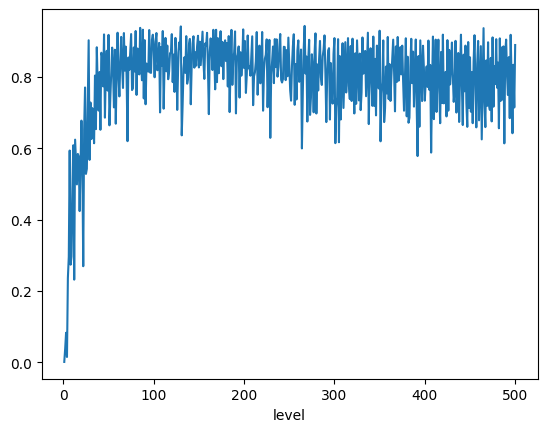

In [11]:
df.groupby('level')['action'].mean().plot()

Заметен прирост сложности на начальных уровнях

Проверим на наличие дубликатов

In [12]:
len(df)

22231214

In [13]:
len(df.drop_duplicates())

10387712

Видим что в датасете большое количество дубликатов. 
Попробуем подсчитать максимальное количество повторяющихся кортежей у пользователя в один момент времени.

In [16]:
df[(df['uid']=='NWVTWWt4UzIxMDUxMTA3MTAyOTA5Mg')&(df['event_time']==1514370274359)]['level'].value_counts()

154    344
144     77
197     54
214     53
167     50
      ... 
212      1
211      1
190      1
202      1
203      1
Name: level, Length: 121, dtype: int64

Можно предположить, что даты и остальные данные в логах приходили в базу от пользователей не в момент прохождение уровней,
а в момент их соединения с сетью интеренет. Поэтому основывать анализ на датах имеет мало смысла.

# Количество уникальных пользавотелей играющих на одном уровне

<AxesSubplot: xlabel='level'>

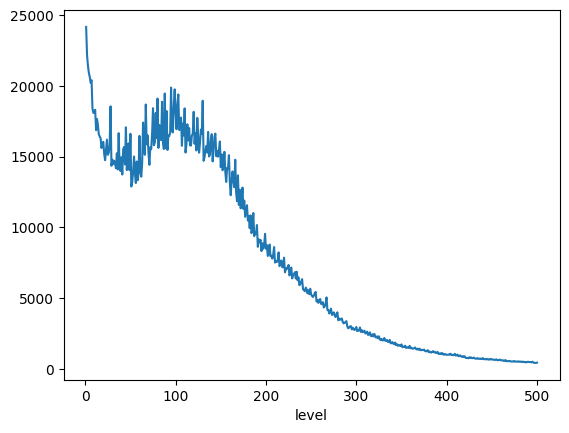

In [17]:
df.groupby('level')['uid'].nunique().plot()

Ожидаемо количество пользователей уменьшается с каждым уровнем. Но есть небольшой приток около сотого уровня, возможно это связано с уровнем сложности, т.к. он как раз возрастает примерно на этих же уровнях.

# Количество попыток прохождения уровня

Проведем подсчет прохождений

In [43]:
df_count = df.groupby(['level','uid'])['uid'].count()

In [44]:
df_count.name = 'count'

In [45]:
df_count = df_count.reset_index()

In [46]:
df_count.head()

,level,uid,count
0,1,M001TWRFNWc5MjQ1MDI3MTAyMjE5MA,1
1,1,M001VTlGalU5MzcwMTI3MTAyMjE5Mg,1
2,1,M010Z2VmOFgzMzgwMTI3MTAyMjE4Mg,1
3,1,M01QQlBMVmo1NTcyODA3MTAyMjE4MQ,1
4,1,M01TMDNDdzA0MDkwNzE3MTAyMjE2MA,1


Сделаем подсчет основных показателей

In [47]:
df_stat = df_count.groupby('level')['count'].agg(['count','mean','median'])

In [51]:
df_stat.head()

,count,mean,median
level,,,
1,24162,1.041180,1.0
2,22177,1.051224,1.0
3,21415,1.103619,1.0
4,20916,1.034423,1.0
5,20625,1.318400,1.0


<AxesSubplot: xlabel='level'>

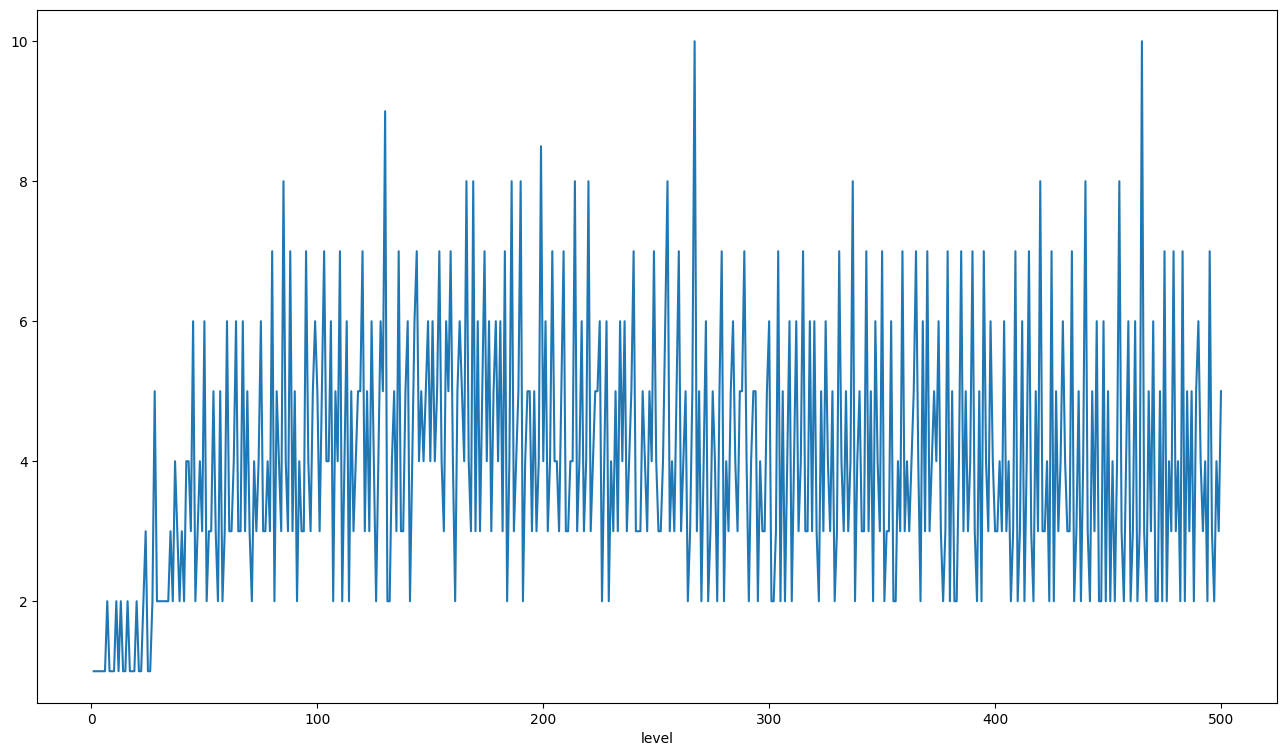

In [54]:
df_stat['median'].plot(figsize=(16,9))

<AxesSubplot: xlabel='level'>

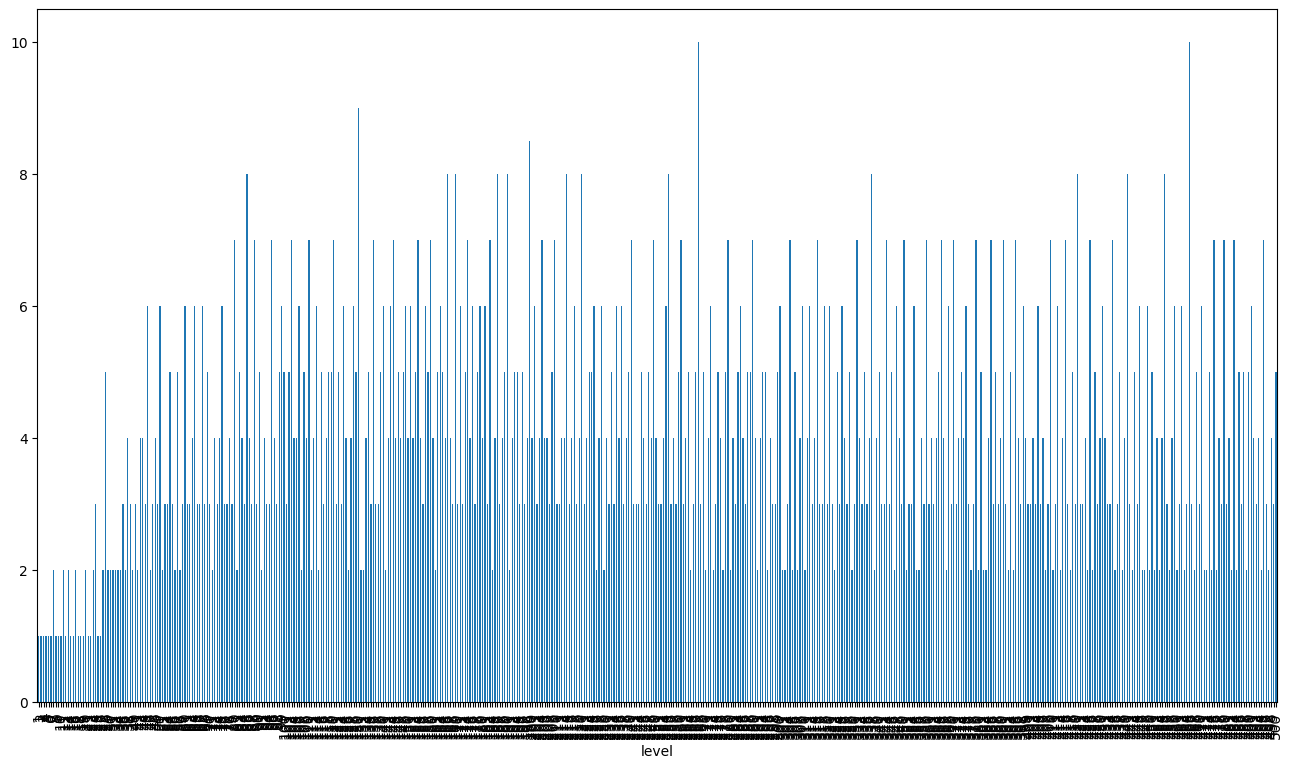

In [48]:
df_stat['median'].plot(kind='bar',figsize=(16,9))

Заметим что количество попыток пройти уровень варьируется возле одного диапозона

In [52]:
df_median = df_stat['median'].reset_index()

In [53]:
df_median['median'].value_counts()

3.0     124
4.0      94
2.0      88
5.0      70
6.0      50
7.0      39
1.0      19
8.0      12
10.0      2
9.0       1
8.5       1
Name: median, dtype: int64

In [55]:
df_median

,level,median
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
...,...,...
495,496,3.0
496,497,2.0
497,498,4.0
498,499,3.0


Можно сделать вывод, что степень сложности растет от нулевого до сотого уровня, дальше он остается на одном уровне. Также видно, по количеству попыток, что степень сложности уровней меняется с периодичностью, что говорит о попытке удержать внимание как можно дольше, меняя сложности уровней. Можно выделить три условные группы, уровни более проходимые с количеством повторений два и меньше, уровни с тремя повторениями и сложные уровни с четырьмя и больше.

In [69]:
df1 = df_median[df_median['median']<3]
df2 = df_median[df_median['median']==3]
df3 = df_median[df_median['median']>3]

In [70]:
df1

,level,median
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
...,...,...
481,482,2.0
483,484,2.0
487,488,2.0
493,494,2.0


In [71]:
df2

,level,median
23,24,3.0
34,35,3.0
37,38,3.0
39,40,3.0
43,44,3.0
...,...,...
479,480,3.0
485,486,3.0
491,492,3.0
495,496,3.0


In [72]:
df3

,level,median
27,28,5.0
36,37,4.0
41,42,4.0
42,43,4.0
44,45,6.0
...,...,...
490,491,4.0
492,493,4.0
494,495,7.0
497,498,4.0
